In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType ,IntegerType, FloatType ,DateType,TimestampType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly
plotly.offline.init_notebook_mode (connected = True)
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA,PCA,TruncatedSVD

import calendar

spark  =  SparkSession \
    .builder \
    .appName("SalesData") \
    .getOrCreate()

In [0]:
schema = StructType([
  StructField("nvoiceNo",IntegerType(),True),
  StructField("StockCode",IntegerType(),True),
  StructField("Description",StringType(),True),
  StructField("Quantity",IntegerType(),True),
  StructField("InvoiceDate",StringType(),True),
  StructField("UnitPrice",FloatType(),True),
  StructField("CustomerID",IntegerType(),True),
  StructField("Country",StringType(),True),
])

In [0]:
sales_data_path = "dbfs:/FileStore/shared_uploads/amitos684@gmail.com/Online_Retail_var2.csv"


sales_raw_df = (spark.read
                    .format("csv")
                    .option("header", "true") 
                    .schema(schema)
                    .load(sales_data_path) 
               )

In [0]:
from pyspark.sql.functions import col ,udf,expr
sales_raw_df = sales_raw_df.distinct()
sales_raw_df = sales_raw_df.filter(col("CustomerID").isNull()!=True )
sales_raw_df = sales_raw_df.filter(col("StockCode").isNull()!=True)

sales_raw_df.show(10)

+--------+---------+--------------------+--------+----------------+---------+----------+--------------+
nvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice|CustomerID| Country|
+--------+---------+--------------------+--------+----------------+---------+----------+--------------+
 536365| 22752|SET 7 BABUSHKA NE...| 2|01/12/2010 08:26| 7.65| 17850|United Kingdom|
 536367| 22310|IVORY KNITTED MUG...| 6|01/12/2010 08:34| 1.65| 13047|United Kingdom|
 536365| 21730|GLASS STAR FROSTE...| 6|01/12/2010 08:26| 4.25| 17850|United Kingdom|
 536367| 22748|POPPY'S PLAYHOUSE...| 6|01/12/2010 08:34| 2.1| 13047|United Kingdom|
 536366| 22633|HAND WARMER UNION...| 6|01/12/2010 08:28| 1.85| 17850|United Kingdom|
 536367| 84969|BOX OF 6 ASSORTED...| 6|01/12/2010 08:34| 4.25| 13047|United Kingdom|
 536365| 71053| WHITE METAL LANTERN| 6|01/12/2010 08:26| 3.39| 17850|United Kingdom|
 536367| 84879|ASSORTED COLOUR B...| 32|01/12/2010 08:34| 1.69| 13047|United Kingdom|
 536367| 22745|POPPY'S PLAYHOUSE...| 6|01/12/2010 08:34| 2.1| 13047|United Kingdom|
 536366| 22632|HAND WARMER RED P...| 6|01/12/2010 08:28| 1.85| 17850|United Kingdom|
+--------+---------+--------------------+--------+----------------+---------+----------+--------------+
only showing top 10 rows

In [0]:
sales_raw_df_t = sales_raw_df
sales_raw_df_t = sales_raw_df_t.withColumn("TotalPrice", expr("UnitPrice * Quantity")) 
sales_raw_df_t.show(5)

+--------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+
nvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice|CustomerID| Country|TotalPrice|
+--------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+
 536365| 22752|SET 7 BABUSHKA NE...| 2|01/12/2010 08:26| 7.65| 17850|United Kingdom| 15.3|
 536365| 21730|GLASS STAR FROSTE...| 6|01/12/2010 08:26| 4.25| 17850|United Kingdom| 25.5|
 536366| 22633|HAND WARMER UNION...| 6|01/12/2010 08:28| 1.85| 17850|United Kingdom| 11.1|
 536365| 71053| WHITE METAL LANTERN| 6|01/12/2010 08:26| 3.39| 17850|United Kingdom| 20.34|
 536367| 84879|ASSORTED COLOUR B...| 32|01/12/2010 08:34| 1.69| 13047|United Kingdom| 54.08|
+--------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+
only showing top 5 rows

#### RFM Analysis 
- Used to segregate the customers based on behaviors

RFM helps in segregating:

- the more recent the purchase, the more responsive the customer is to promotions
- the more frequently the customer buys, the more engaged and satisfied they are
- monetary value differentiates heavy spenders from low-value purchasers

In [0]:
pandas_df = sales_raw_df_t.toPandas()

pandas_df['InvoiceDate']= pd.to_datetime(pandas_df['InvoiceDate'],infer_datetime_format=True)


In [0]:
def RFM_Analysis(df):
  lastdate = datetime(2012,1,1)
  cleaned_dataset = df[df['TotalPrice']>=0]
  recent = (lastdate - cleaned_dataset.groupby("CustomerID")["InvoiceDate"].last()).dt.days
  frequent = cleaned_dataset.groupby("CustomerID")["InvoiceDate"].count()
  monetary = cleaned_dataset.groupby("CustomerID")["TotalPrice"].sum()
  
  recent_quantile = recent.quantile(q=[0.25,0.5,0.75])
  recent_quantile
  
  frequent_quantile = frequent.quantile(q=[0.25,0.5,0.75])
  frequent_quantile
  
  monetary_quantile = monetary.quantile(q=[0.25,0.5,0.75])
  monetary_quantile
  
  rfm = pd.DataFrame(data=[recent,frequent,monetary])
  rfm = rfm.transpose()
  rfm.columns = ["recent","frequent","monetary"]
  return rfm

def get_kmeans_wcss(data, n_limit=15):
    from sklearn.cluster import KMeans
    wcss = [] #Within cluster sum of squares (WCSS)
    for i in range(1,n_limit):
        km = KMeans(init='k-means++', n_clusters=i, n_init=10)
        km.fit(data)
        wcss.append(km.inertia_)
    plt.title("Elbow Method")
    plt.plot(range(1, n_limit), wcss)
    plt.xlabel("Number of clusters")
    plt.ylabel("WCSS")
    return wcss

recent frequent monetary
CustomerID 
12346 347.0 1.0 77183.593750
12347 61.0 162.0 3653.449951
12348 241.0 27.0 1437.239990
12349 40.0 68.0 1372.420044
12350 332.0 13.0 258.000000
12352 295.0 76.0 1373.239990
12353 226.0 4.0 89.000000
12354 254.0 57.0 1062.800049
12355 117.0 9.0 363.100006
12356 149.0 55.0 2406.629883

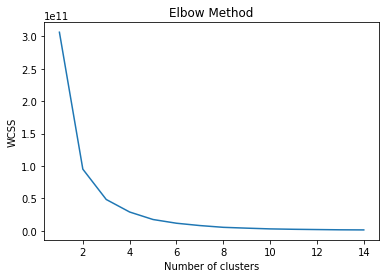

In [0]:
rfm_df = RFM_Analysis(pandas_df)
print(rfm_df.head(10))
_ =get_kmeans_wcss(rfm_df)

- Elbow method suggests that ideal number of clusters would be 3 (knee point)-->>K=3
- We will try to segregate customers based on RFM analysis. First, we'll create clusters and see characterstics of each cluster

In [0]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

def Spark_KMeans(rfm_df,pandas_df):
  
  lastdate = datetime(2012,1,1)
  cleaned_dataset = pandas_df[pandas_df['TotalPrice']>=0]
  recent = (lastdate - cleaned_dataset.groupby("CustomerID")["InvoiceDate"].last()).dt.days
  frequent = cleaned_dataset.groupby("CustomerID")["InvoiceDate"].count()
  monetary = cleaned_dataset.groupby("CustomerID")["TotalPrice"].sum()
  recent_quantile = recent.quantile(q=[0.25,0.5,0.75])
  frequent_quantile = frequent.quantile(q=[0.25,0.5,0.75])
  monetary_quantile = monetary.quantile(q=[0.25,0.5,0.75])

  
  data_customer = spark.createDataFrame(rfm_df)
  assemble = VectorAssembler(inputCols=["recent","frequent","monetary"], outputCol='features')
  assembled_data = assemble.transform(data_customer)
  
  #assembled_data.show(2)

 
  scale = StandardScaler(inputCol='features',outputCol='standardized')
  data_scale=scale.fit(assembled_data)
  data_scale_output = data_scale.transform(assembled_data)
  
  #data_scale_output.show(2)

  # Trains a k-means model.
  kmeans = KMeans().setK(3).setSeed(1)
  model = kmeans.fit(data_scale_output)

  # Make predictions
  predictions = model.transform(data_scale_output)

  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator()

  silhouette = evaluator.evaluate(predictions)
  print("Silhouette with squared euclidean distance = " + str(silhouette))

  # Shows the result.
  centers = model.clusterCenters()
  print("Cluster Centers: ")
  for center in centers:
      print(center)

  predictions.groupBy('prediction').sum("recent","frequent","monetary").orderBy('prediction').show()
  
  



In [0]:
Spark_KMeans(rfm_df,pandas_df)

Silhouette with squared euclidean distance = 0.9940270855777653
Cluster Centers: 
[ 165.0806151 76.63863001 1379.74351615]
[1.83750000e+02 6.85250000e+02 2.17047301e+05]
[ 167.68421053 1401.84210526 63325.09292763]
+----------+-----------+-------------+-----------------+
prediction|sum(recent)|sum(frequent)| sum(monetary)|
+----------+-----------+-------------+-----------------+
 0| 708526.0| 328933.0|5921859.171302795|
 1| 735.0| 2741.0| 868189.203125|
 2| 3186.0| 26635.0| 1203176.765625|
+----------+-----------+-------------+-----------------+

## inference
##### RECENCY 
- Cluster 0 have low recency, which is not appreciable.
- Cluster 1,2 are having high recency, suggesting that they are more prone to marketing

##### FREQUENCY 
- Cluster 0 has low frequency, which means customers are not doing transactions frequently
- Cluster 1,2 are having better frequency, suggesting that they are more satisfied in general

##### MONETARY 
- Cluster 0 has lowest value suggesting they are having lowest affordability
- Cluster 1 are heavy spenders
- Cluster 2 comes in middle